## Perform linear regression calculations from first principles

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

In [200]:
# create a linear regression class, that after pushing in 2 lists, generates all linear regression statistics
class LinearReg:
    # create a class to generate and store all linear regression variables
    
    # constructor of the class
    def __init__(self, x: list, y: list):
        # store x and y in a dataframe
        self.df = pd.DataFrame(list(zip(x, y)), columns=['x', 'y'])
        self.mean_x, self.mean_y = df['x'].mean(), df['y'].mean()
        self.std_x, self.std_y = df['x'].std(), df['y'].std()
        self.n = len(self.df)
        
        # generate standardised values
        self.df['standard_x'] = (df['x'] - self.mean_x) / self.std_x
        self.df['standard_y'] = (df['y'] - self.mean_y) / self.std_y

        # generate correlation coefficient from first principles: average product of standardised values of x and y
        # Note we can also use the correlation coefficient
        self.corr = sum(self.df.standard_x * self.df.standard_y) / self.n
        self.r_squared = self.corr ** 2
        
        # generate linear coefficients
        self.b1 = self.corr * self.std_y / self.std_x
        self.b0 = self.mean_y - b1 * self.mean_x
        
        # generate errors in df
        self.df['lin_y'] = self.b0 + self.b1 * self.df.x
        self.df['err'] = self.df.y - self.df.lin_y

In [201]:
model = LinearReg(x, y)

In [202]:
model.df

,x,y,standard_x,standard_y,lin_y,err
0,8450,208500,-0.207071,0.347154,176583.887684,31916.112316
1,9600,181500,-0.091855,0.007286,178997.201341,2502.798659
2,11250,223500,0.073455,0.535970,182459.781805,41040.218195
3,9550,140000,-0.096864,-0.515105,178892.274660,-38892.274660
4,14260,250000,0.375020,0.869545,188776.367986,61223.632014
...,...,...,...,...,...,...
1455,7917,175000,-0.260471,-0.074534,175465.369267,-465.369267
1456,13175,210000,0.266316,0.366036,186499.459014,23500.540986
1457,9042,266500,-0.147760,1.077242,177826.219584,88673.780416
1458,9717,142125,-0.080133,-0.488356,179242.729774,-37117.729774


In [205]:
model.corr

0.2636626392454669

In [184]:
x = df.x
y = df.y

In [186]:
df = pd.DataFrame(list(zip(x, y)), columns=['x', 'y'])

In [183]:
df

,x,y,standard_x,standard_y
0,8450,208500,-0.207071,0.347154
1,9600,181500,-0.091855,0.007286
2,11250,223500,0.073455,0.535970
3,9550,140000,-0.096864,-0.515105
4,14260,250000,0.375020,0.869545
...,...,...,...,...
1455,7917,175000,-0.260471,-0.074534
1456,13175,210000,0.266316,0.366036
1457,9042,266500,-0.147760,1.077242
1458,9717,142125,-0.080133,-0.488356


In [178]:
# import relevant datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Univariate Linear Regression

In [179]:
# remove non-numerical columns
train_df = train_df.loc[:, train_df.dtypes != 'object']

In [180]:
# selecting lot area for linear regression
df = train_df[['LotArea', 'SalePrice']]

## Calculate correlation coefficient between variables

In [181]:
# calculate standardised variables
df = df.rename(columns={'LotArea':'x', 'SalePrice':'y'})
df['standard_x'] = (df['x'] - df['x'].mean()) / df['x'].std()
df['standard_y'] = (df['y'] - df['y'].mean()) / df['y'].std()

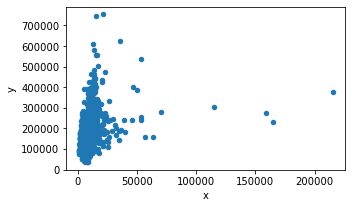

In [182]:
df.plot.scatter(x='x', y='y', figsize=(5, 3))
plt.show()

In [8]:
# calculate correlation from first principles
corr = (sum(df['standard_x'] * df['standard_y'])) / len(df)
print(corr)

0.2636626392454669


In [9]:
# calculation using covariance instead of conversion into standardised variables
new_corr = (df['x'].cov(df['y'])) / (df['x'].std() * df['y'].std())

In [10]:
# calculate corr using function
df.corr()

,x,y,standard_x,standard_y
x,1.000000,0.263843,1.000000,0.263843
y,0.263843,1.000000,0.263843,1.000000
standard_x,1.000000,0.263843,1.000000,0.263843
standard_y,0.263843,1.000000,0.263843,1.000000


### Calculating linear coefficients

In [11]:
# b0 and b1 for Y and X
# b1 is literally the scaling factor on the correlation coefficient
b1 = corr * df['y'].std() / df['x'].std()
b0 = df['y'].mean() - b1 * df['x'].mean()

In [12]:
# plot new chart based on linear regression
pred_x = [x for x in range(0, 200000, 1)]
pred_y = [b0 + b1*x for x in range(0, 200000, 1)]

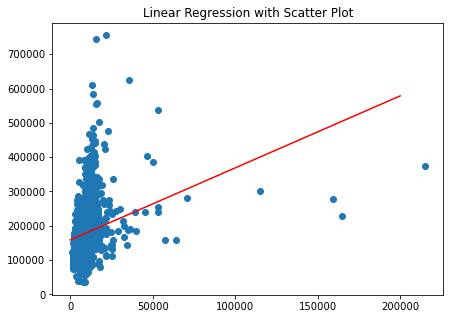

In [13]:
# plot predictions
plt.figure(figsize=(7, 5))
plt.scatter(x=df['x'], y=df['y'])
plt.plot(pred_x, pred_y, c='red')
plt.title('Linear Regression with Scatter Plot')
plt.show()

In [14]:
# calculating R-squared from correlation coefficient
r_squared = corr * corr

In [15]:
df['lin_y'] = b0 + b1 * df['x']

In [16]:
# calculating SSE
df['err'] = df['lin_y'] - df['y']
error_var = df['err'].var()  # variance of the erros
y_var = df['y'].var()  # variance of the y valueas

In [17]:
manual_r_squared = 1 - (error_var) / y_var

In [18]:
sse = sum(df['err'] * df['err'])
rmse = np.sqrt(sse / len(df))

### Implement Checks on Linear Regression Examples

#### Checking on Linearity between X and the mean of Y
1. Linearity: Points should be symmetrically distributed around a horizontal line, with a roughly constant variance

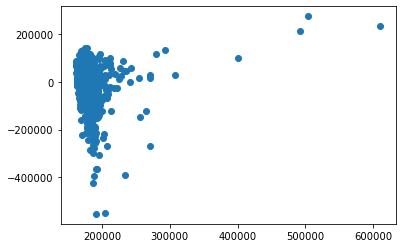

In [48]:
# plot residuals against independent variables
plt.scatter(df.lin_y, df.err)
plt.show()

Observations from above, majority of points are symmetricallty distributed around horizontal line, but there are outliers

#### Checking on Homoscedasticity
1. Plot Residuals against predicted values
2. Scale-Location Plot: Square-root of standardised residuals vs predicted value
3. Make sure no pattern in residuals and that they are equally split around the y=0 line
4. The variance of residuals

Fix:
1. Perform transformations --> Log, or any other transformation to find the right independent variables

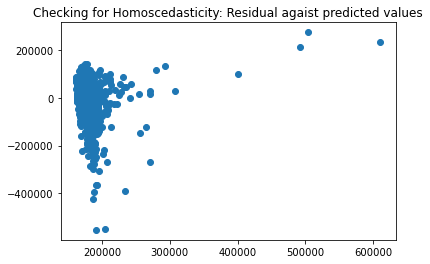

In [38]:
# plot residuals against predicted values, and also scale-location plot
plt.scatter(df.lin_y, df.err)
plt.title('Checking for Homoscedasticity: Residual agaist predicted values')
plt.show()

In [60]:
# plot scale-location plot; the root of the absolute of the errors
df['root_standardised_residual'] = np.sqrt(np.abs(df['err'] / df['lin_y'].apply(np.sqrt)))

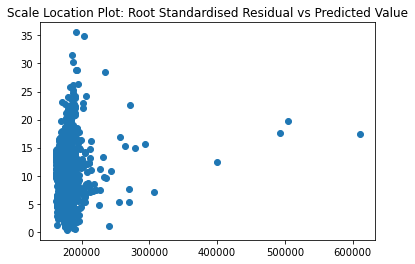

In [61]:
plt.scatter(df.lin_y, df.root_standardised_residual)
plt.title('Scale Location Plot: Root Standardised Residual vs Predicted Value')
plt.show()

### Checking on Statistical Independence of Errors

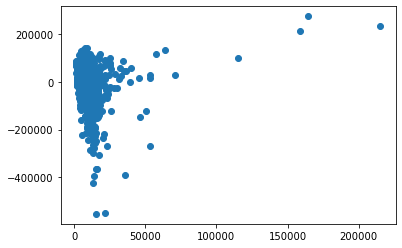

In [50]:
# ensure no correlation between consecutive errors
# plot residuals against independent variable. There should be no trend no matter how the rows are sorted
plt.scatter(df.x, df.err)
plt.show()

### Checking on Normality of the Error Distribution

In [65]:
# calculating mean and SD of errors, assuming a normal distribution
err_mean = df['err'].mean()
err_std = df['err'].std()

In [67]:
df['err_percentile'] = st.percentileofscore(df.err, df.err)

In [80]:
df['theoretical_err'] = (st.norm.ppf(df['err_percentile']/100) * err_std) + err_mean

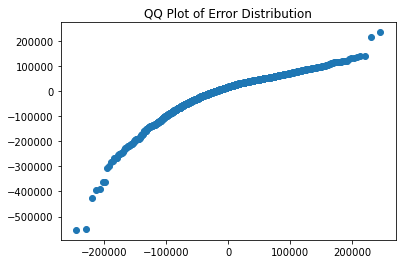

In [85]:
# plot actual error over theoretical error assuming normality of the error distribution
plt.scatter(df.theoretical_err, df.err)
plt.title('QQ Plot of Error Distribution')
plt.show()

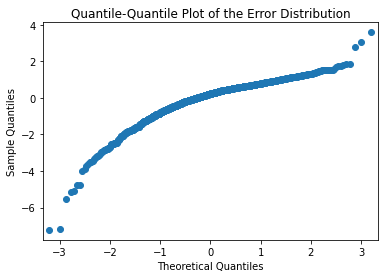

In [100]:
sm.qqplot(df.err, fit=True)
plt.title('Quantile-Quantile Plot of the Error Distribution')
plt.show()

### Tabulate Standard Errors of the Linear Regression Model
1. Standard Error of the Regression
2. Standard Error of the Mean
3. Standard Error of the Forecast (Prediction)
4. Confidence Interval of the Forecast
5. Standard Error of the Linear Coefficients

In [104]:
# standard error of the regression
se_reg = np.sqrt(sum(df.err ** 2) / (len(df)-2))

In [111]:
# scaling factor for checking --> another way
se_reg_v2 = df.err.std() * np.sqrt((len(df.err) - 1) / (len(df.err)-2))

In [114]:
# standard error of the mean, at a certain X value --> tabulate for all X values
df['se_mean'] = (se_reg / np.sqrt(len(df))) * np.sqrt(1 + ((df.x - df.x.mean())**2)/df.x.var())

The SE_Mean is larger for values that are further away from the mean

In [122]:
df['se_forecast'] = np.sqrt(se_reg ** 2 + df['se_mean'] ** 2)

In [130]:
# obtain confidence interval of the forecast
# confidence interval = critical t-value * standard error
df['se_forecast_conf_95'] = st.norm.ppf(0.95) * df['se_forecast']
df['se_forecast_conf_90'] = st.norm.ppf(0.90) * df['se_forecast']

In [161]:
# obtain standard error of the linear coefficients
se_b1 = se_reg / (np.sqrt(len(df))) * (np.sqrt(1 + (df.x.mean()**2 / df.x.var())))
se_b0 = se_reg / np.sqrt(len(df)) * (1 / df.x.std())

In [162]:
se_b0

0.20098865411734299

In [163]:
se_b1

2914.192173222943

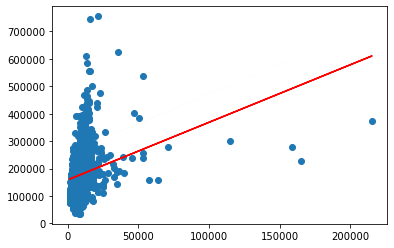

In [149]:
plt.scatter(df.x, df.y)
plt.plot(df.x, df.lin_y, color='red')
plt.fill(df.x, df.lin_y + df.se_forecast_conf_90, df.lin_y - df.se_forecast_conf_90)
plt.show()

In [125]:
st.norm.ppf(0.95)

1.6448536269514722